In [2]:
import pymc as pm
import numpy as np, scipy

import seaborn as sns, matplotlib.pyplot as plt
sns.set_theme()

In [3]:
def f_of_x(X:np.ndarray, b:float=2.0, a:float=2.0, c:float=.8, noise=None):
    if noise is None:
        noise = scipy.stats.norm.rvs(size=len(X)) * 0.5
    return b * np.sin(X)+ a + c*X + noise

In [4]:
x_range = np.linspace(0, 2*np.pi, 100)
x = scipy.stats.uniform.rvs(size=15) * 2*np.pi
x = x[np.argsort(x)]
y = f_of_x(x)
y_true = f_of_x(x_range, noise=0.0)
x = x.reshape(-1,1)


In [26]:
y = np.array([3.02279205, 2.62706765, 4.07645395, 5.6172169 , 5.40195956,
        5.68568616, 4.61712918, 4.1211748 , 4.38532079, 4.15322815,
        3.33940025, 4.76644136, 5.28222082, 6.03887021, 7.34193673])

x = np.array([[0.01320724],
       [0.49287519],
       [0.83716699],
       [1.40041204],
       [2.02632083],
       [2.76750843],
       [3.13847698],
       [3.41643473],
       [3.41803355],
       [3.85176846],
       [4.49765309],
       [4.91798341],
       [5.47021841],
       [5.91772162],
       [6.26220967]])

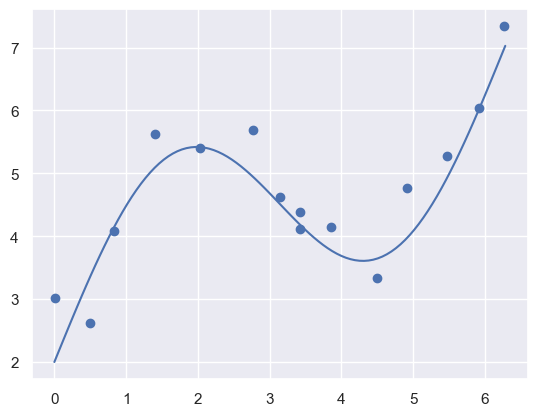

In [6]:
plt.scatter(x, y)
plt.plot(x_range, y_true)

### PyMC Guassian Process Implementation

In [187]:
with pm.Model() as model_gp:

    l = pm.Gamma("l", alpha=2, beta=1)
    eta = pm.Exponential("eta", 1)

    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=l)
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X = x)

    tau = pm.Exponential("tau", 1)

    obs = pm.Normal("obs", mu=f, tau=tau, observed=y)

In [188]:
with model_gp:
    trace_gp = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [l, eta, f_rotated_, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot: title={'center': 'f_rotated_'}>,
        <AxesSubplot: title={'center': 'f_rotated_'}>],
       [<AxesSubplot: title={'center': 'l'}>,
        <AxesSubplot: title={'center': 'l'}>],
       [<AxesSubplot: title={'center': 'eta'}>,
        <AxesSubplot: title={'center': 'eta'}>],
       [<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>],
       [<AxesSubplot: title={'center': 'f'}>,
        <AxesSubplot: title={'center': 'f'}>]], dtype=object)

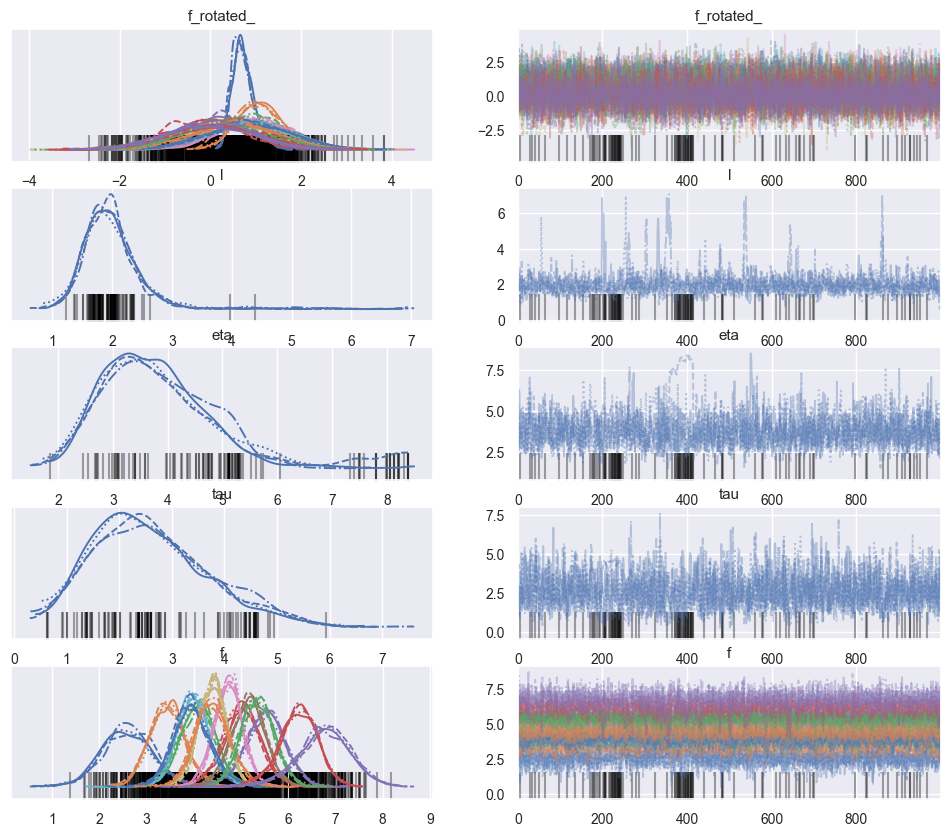

In [189]:
pm.plot_trace(trace_gp)

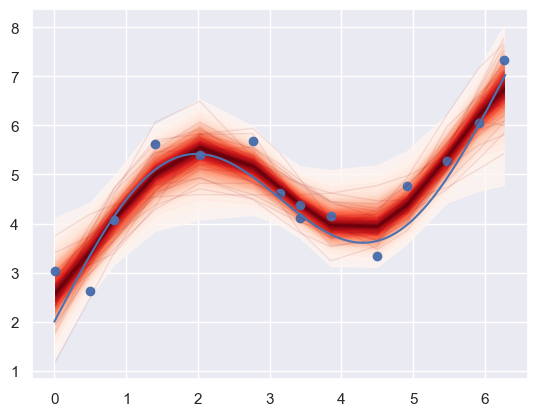

In [190]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace_gp["posterior"]["f"][3, :, :], x)
ax.plot(x_range, y_true)
ax.scatter(x, y)

In [35]:
def cov_matrix(x, l, eta):
    return eta**2 * np.exp(-(x - x.T)**2 / (2*l**2))

In [38]:
x

array([[0.01320724],
       [0.49287519],
       [0.83716699],
       [1.40041204],
       [2.02632083],
       [2.76750843],
       [3.13847698],
       [3.41643473],
       [3.41803355],
       [3.85176846],
       [4.49765309],
       [4.91798341],
       [5.47021841],
       [5.91772162],
       [6.26220967]])

In [41]:
from aesara import tensor as at
from aesara import function

In [48]:
xt = at.dmatrix("xt")

zt = np.exp(-(xt - xt.T)**2)

fun = function([xt], zt)

In [49]:
fun(x)

array([[1.00000000e+00, 7.94468976e-01, 5.07169674e-01, 1.45972482e-01,
        1.73766778e-02, 5.07418199e-04, 5.72942122e-05, 9.33296923e-06,
        9.23193212e-06, 3.98901132e-07, 1.84598176e-09, 3.56657854e-11,
        1.16723219e-13, 7.22878827e-16, 1.09846660e-17],
       [7.94468976e-01, 1.00000000e+00, 8.88219090e-01, 4.38838799e-01,
        9.52304504e-02, 5.66212296e-03, 9.12603704e-04, 1.94087711e-04,
        1.92281247e-04, 1.25955876e-05, 1.08312418e-07, 3.13203539e-09,
        1.74105368e-11, 1.65640140e-13, 3.50277690e-15],
       [5.07169674e-01, 8.88219090e-01, 1.00000000e+00, 7.28152346e-01,
        2.43147541e-01, 2.40837467e-02, 5.01146160e-03, 1.29063353e-03,
        1.28002944e-03, 1.13033986e-04, 1.51641966e-06, 5.85688616e-08,
        4.76208439e-10, 6.16560192e-12, 1.65287820e-13],
       [1.45972482e-01, 4.38838799e-01, 7.28152346e-01, 1.00000000e+00,
        6.75865077e-01, 1.54285185e-01, 4.87587927e-02, 1.71741920e-02,
        1.70637908e-02, 2.45617922e-0